In [165]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt

In [166]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


In [167]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [168]:
from torchvision import transforms
data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [169]:
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir , transform = data_transform)
test_data = datasets.ImageFolder(root = test_dir , transform = data_transform)

In [170]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [171]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [172]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data , batch_size=32,shuffle=True)
test_dataloader = DataLoader(dataset=test_data , batch_size=32 , shuffle=False)

In [173]:
train_dataloader , test_dataloader , class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c14640f0d60>,
 ['pizza', 'steak', 'sushi'])

In [174]:
#above we have transformed data manually
#torchvision.models can help in automatic transformation
weight = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weight

EfficientNet_B0_Weights.IMAGENET1K_V1

In [175]:
auto_transform = weight.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [176]:
#using autotransforms to transform the data
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir , transform = auto_transform)
test_data = datasets.ImageFolder(root = test_dir , transform = auto_transform)

In [177]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data , batch_size=32,shuffle=True)
test_dataloader = DataLoader(dataset=test_data , batch_size=32 , shuffle=False)

In [178]:
train_dataloader , test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c14640f1c30>,
 <torch.utils.data.dataloader.DataLoader at 0x7c14640f10f0>)

In [179]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

EfficientNet_B0_Weights.get_state_dict = get_state_dict

weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

In [180]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [181]:
!pip install torchinfo

In [182]:
import torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)
# model - the model we'd like to get a summary of.
# input_size - the shape of the data we'd like to pass to our model, for the case of efficientnet_b0, the input size is (batch_size, 3, 224, 224), though other variants of efficientnet_bX have different input sizes.
# Note: Many modern models can handle input images of varying sizes thanks to torch.nn.AdaptiveAvgPool2d(), this layer adaptively adjusts the output_size of a given input as required. You can try this out by passing different size input images to summary() or your models.
# col_names - the various information columns we'd like to see about our model.
# col_width - how wide the columns should be for the summary.
# row_settings - what features to show in a row.

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [159]:
# TinyVGG had 8,083 parameters vs. 5,288,548 parameters for efficientnet_b0, an increase of 654 times

In [160]:
#freezing all layers in features section
for param in model.features.parameters():
  param.requires_grad = False

In [161]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2 ,inplace=True),
    nn.Linear(in_features=1280,out_features=len(class_names),bias=True)
)

In [162]:
#checking updated summary of model

summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [163]:
lossfn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters() , lr=0.001)

In [143]:
torch.manual_seed(42)

epochs = 10

for epoch in range(epochs):

    trainloss = 0
    trainacc = 0
    for batch, (x, y) in enumerate(train_dataloader):
        model.train()

        ypred = model(x)

        loss = lossfn(ypred, y)
        trainloss += loss
        trainacc += accuracy_fn(y_true=y, y_pred=ypred.argmax(dim=1))

        optimiser.zero_grad()

        loss.backward()

        optimiser.step()

    trainloss /= len(train_dataloader)
    trainacc /= len(train_dataloader)

    testloss, testacc = 0, 0
    model.eval()
    with torch.inference_mode():
        for x, y in test_dataloader:

            testpred = model(x)

            testloss += lossfn(testpred, y)

            testacc += accuracy_fn(y_true=y, y_pred=testpred.argmax(dim=1))

        testloss /= len(test_dataloader)

        testacc /= len(test_dataloader)

    print(f"Train loss: {trainloss} | Test loss: {testloss} | Train Accuracy : {trainacc} | Test Accuracy : {testacc} ")


Train loss: 1.1307909488677979 | Test loss: 0.922137439250946 | Train Accuracy : 37.5 | Test Accuracy : 59.753787878787875 
Train loss: 0.9110342264175415 | Test loss: 0.8400092124938965 | Train Accuracy : 64.0625 | Test Accuracy : 67.04545454545455 
Train loss: 0.7518502473831177 | Test loss: 0.6791947484016418 | Train Accuracy : 87.109375 | Test Accuracy : 81.53409090909092 
Train loss: 0.7372984290122986 | Test loss: 0.6258557438850403 | Train Accuracy : 72.265625 | Test Accuracy : 87.59469696969695 
Train loss: 0.628366231918335 | Test loss: 0.6359128355979919 | Train Accuracy : 77.734375 | Test Accuracy : 78.40909090909092 
Train loss: 0.5817849040031433 | Test loss: 0.5777844786643982 | Train Accuracy : 78.125 | Test Accuracy : 84.56439393939394 
Train loss: 0.5572229027748108 | Test loss: 0.5925083160400391 | Train Accuracy : 78.515625 | Test Accuracy : 79.45075757575758 
Train loss: 0.4883381128311157 | Test loss: 0.5144565105438232 | Train Accuracy : 78.90625 | Test Accuracy :

In [144]:
trainacc , testacc

(78.125, 82.48106060606061)

In [145]:
#making predictions on test images

In [146]:
from PIL import Image
from typing import List , Tuple
def plotimagepredictimage(model:torch.nn.Module , imagepath:str , classnames: List[str] , imagesize:Tuple[int ,int]=(224,224) , transform:torchvision.transforms = None):

  image = Image.open(imagepath)

  if transform != None:
    imagetransform = transform
  else:
    imagetransform = transforms.Compose([
        transforms.Resize(imagesize),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])

  model.eval()
  with torch.inference_mode():
    transformimage = imagetransform(image).unsqueeze(dim=0)
    imagepred = model(transformimage)
    imagepredprob = torch.softmax(imagepred,dim=1)
    imagepredlabel = torch.argmax(imagepredprob,dim=1)

  plt.imshow(image)
  plt.title(f"Predicted Image: {class_names[imagepredlabel]} | Probability : {imagepredprob.max()}")
  plt.axis(False)

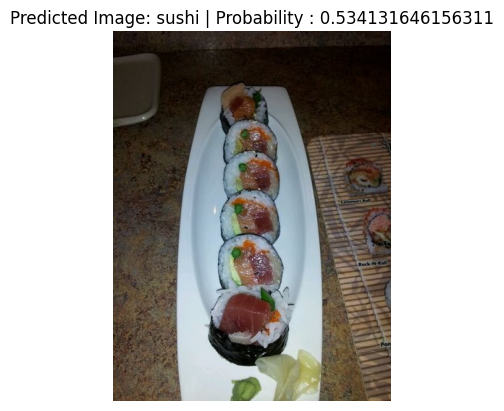

In [147]:
import random
n = 3
testimagepathglobal = list(Path(test_dir).glob("*/*.jpg"))
testimagepathlocal = random.sample(population=testimagepathglobal, k=n)

for i in testimagepathlocal:
  plotimagepredictimage(model,i,class_names,imagesize=(224,224))


In [148]:
#predicting on custom data

In [149]:
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data/04-pizza-dad.jpeg already exists, skipping download.


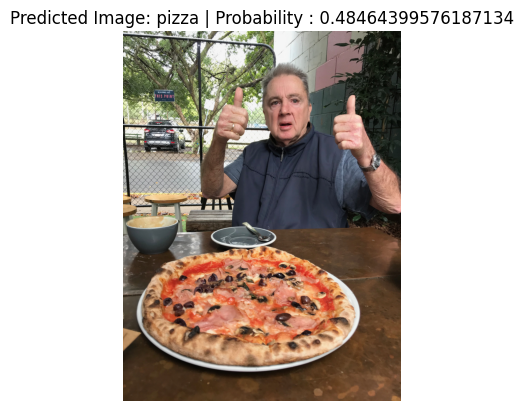

In [150]:
plotimagepredictimage(model,custom_image_path,class_names)

In [151]:
#training the model with double the data and then finding the accuracy

In [152]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [153]:
train_dir20 = image_path / "train"
test_dir20 = image_path / "test"

In [154]:
data_transform20 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [155]:
from torchvision import datasets
train_data20 = datasets.ImageFolder(root=train_dir20 , transform=data_transform20 , target_transform = None)
test_data20 = datasets.ImageFolder(root=test_dir20 , transform = data_transform20 , target_transform = None)

In [156]:
from torch.utils.data import DataLoader
train_dataloader20 = DataLoader(dataset=train_data20 , batch_size=32,shuffle=True)
test_dataloader20 = DataLoader(dataset=test_data20 , batch_size=32, shuffle=False)

In [157]:
lossfn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(params=model.parameters(),lr=0.001)

In [158]:
epochs = 10

for epoch in range(epochs):

    trainloss = 0
    trainacc = 0
    for batch, (x, y) in enumerate(train_dataloader20):
        model.train()

        ypred = model(x)

        loss = lossfn(ypred, y)
        trainloss += loss
        trainacc += accuracy_fn(y_true=y, y_pred=ypred.argmax(dim=1))

        optimiser.zero_grad()

        loss.backward()

        optimiser.step()

    trainloss /= len(train_dataloader20)
    trainacc /= len(train_dataloader20)

    testloss, testacc = 0, 0
    model.eval()
    with torch.inference_mode():
        for x, y in test_dataloader20:

            testpred = model(x)

            testloss += lossfn(testpred, y)

            testacc += accuracy_fn(y_true=y, y_pred=testpred.argmax(dim=1))

        testloss /= len(test_dataloader20)

        testacc /= len(test_dataloader20)

    print(f"Train loss: {trainloss} | Test loss: {testloss} | Train Accuracy : {trainacc} | Test Accuracy : {testacc} ")

Train loss: 0.532406210899353 | Test loss: 0.3685736656188965 | Train Accuracy : 81.875 | Test Accuracy : 94.7159090909091 
Train loss: 0.47153013944625854 | Test loss: 0.3384093642234802 | Train Accuracy : 86.45833333333333 | Test Accuracy : 92.55681818181817 
Train loss: 0.40544605255126953 | Test loss: 0.32265952229499817 | Train Accuracy : 88.54166666666667 | Test Accuracy : 92.8409090909091 
Train loss: 0.3682011067867279 | Test loss: 0.29387742280960083 | Train Accuracy : 86.66666666666667 | Test Accuracy : 91.93181818181817 
Train loss: 0.3022170960903168 | Test loss: 0.2748194932937622 | Train Accuracy : 92.70833333333333 | Test Accuracy : 93.4659090909091 
Train loss: 0.2964107394218445 | Test loss: 0.2782791256904602 | Train Accuracy : 92.5 | Test Accuracy : 91.93181818181817 
Train loss: 0.3311726450920105 | Test loss: 0.25663068890571594 | Train Accuracy : 89.79166666666667 | Test Accuracy : 93.80681818181817 
Train loss: 0.34500449895858765 | Test loss: 0.2670285701751709 

In [185]:
trainacc, testacc

(94.375, 92.27272727272728)

In [ ]:
#increasing the data has increased the accuracy